<div style="text-align:center;">
    <h1>🔬 Target Trial Emulation with Clustering (TTE-V2)</h1>
    <h3>Assignment: Integrating Clustering into Target Trial Emulation</h3>
    <h4>Authors:</h4>
    <ul style="list-style:none;">
        <li>👤 Elgen Mar Arinasa </li>
        <li>👤 Shawn Jurgen Mayol </li>
    </ul>
    <hr>
</div>

### 📖 **Introduction**  

Target Trial Emulation (TTE) is a framework designed to estimate causal effects in observational studies while mimicking randomized controlled trials (RCTs). However, traditional TTE does not incorporate **unsupervised learning techniques** like clustering, which can help refine patient groups and improve estimation accuracy.  

In this **TTE-V2** notebook, we extend our initial TTE implementation by integrating **K-Means clustering** at a strategic point in the workflow. Clustering will be used to identify **distinct patient subgroups** based on baseline characteristics before treatment effects are analyzed. This allows us to compare how causal inference results differ **before and after clustering**, providing additional insights into treatment response patterns.

---

## 🎯 Objectives
This notebook aims to accomplish the following:  
1. **Preprocess the dataset** by selecting relevant patient features and standardizing them for clustering.  
2. **Implement K-Means clustering** to segment patients into distinct subgroups based on baseline characteristics.  
3. **Evaluate clustering performance** using **Silhouette Score** and **visual analysis** of patient feature distributions.  
4. **Analyze treatment and outcome variations** across clusters to assess potential biases and patterns.  
5. **Compare results between TTE and TTE-V2** to determine whether clustering improves causal inference.  


---

## 📚 Import Required Libraries


In [23]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


## 🔄 Data Preprocessing for Clustering
Before applying clustering, we need to:
1. **Load the dataset** generated in `TTE.ipynb`.
2. **Select relevant patient features** for clustering.
3. **Standardize features** to ensure fair clustering.


In [24]:
# Load the processed dataset from TTE.ipynb
tte_data = pd.read_csv("data_censored.csv")

# Display dataset info
print("📊 Dataset Info:")
print(tte_data.info())

# Display the first few rows
tte_data.head()


📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         725 non-null    int64  
 1   period     725 non-null    int64  
 2   treatment  725 non-null    int64  
 3   x1         725 non-null    int64  
 4   x2         725 non-null    float64
 5   x3         725 non-null    int64  
 6   x4         725 non-null    float64
 7   age        725 non-null    int64  
 8   age_s      725 non-null    float64
 9   outcome    725 non-null    int64  
 10  censored   725 non-null    int64  
 11  eligible   725 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 68.1 KB
None


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


### ✅ Feature Selection
We select key **baseline characteristics** to form meaningful patient clusters:
- `age`: Patient's age at the start of observation.
- `x1, x2, x3, x4`: Covariates representing patient characteristics.


In [25]:
# Select features for clustering
cluster_features = ["age", "x1", "x2", "x3", "x4"]

# Check for missing values
print("🔍 Missing Values in Selected Features:\n", tte_data[cluster_features].isnull().sum())

# Fill missing values (if any) with column median
tte_data[cluster_features] = tte_data[cluster_features].fillna(tte_data[cluster_features].median())

# Verify after filling
print("\n✅ Missing Values Handled:\n", tte_data[cluster_features].isnull().sum())


🔍 Missing Values in Selected Features:
 age    0
x1     0
x2     0
x3     0
x4     0
dtype: int64

✅ Missing Values Handled:
 age    0
x1     0
x2     0
x3     0
x4     0
dtype: int64


## 🎯 Standardizing Features for Clustering
Since features have different scales, we apply **StandardScaler** to normalize them.


In [26]:
# Standardize features
scaler = StandardScaler()
tte_data_scaled = scaler.fit_transform(tte_data[cluster_features])

# Convert back to DataFrame
tte_data_scaled = pd.DataFrame(tte_data_scaled, columns=cluster_features)

# Display standardized feature summary
tte_data_scaled.describe()


,age,x1,x2,x3,x4
count,7.250000e+02,7.250000e+02,7.250000e+02,7.250000e+02,7.250000e+02
mean,-1.225074e-16,4.900295e-17,-1.347581e-17,-2.940177e-17,-9.800589e-18
std,1.000690e+00,1.000690e+00,1.000690e+00,1.000690e+00,1.000690e+00
min,-2.460091e+00,-8.259144e-01,-3.120588e+00,-9.741277e-01,-2.706853e+00
25%,-6.843889e-01,-8.259144e-01,-6.377917e-01,-9.741277e-01,-5.825478e-01
50%,7.662636e-02,-8.259144e-01,1.052535e-02,-9.741277e-01,-4.154172e-02
75%,6.685271e-01,1.210779e+00,6.697560e-01,1.026559e+00,5.697041e-01
max,2.528787e+00,1.210779e+00,4.094038e+00,1.026559e+00,2.304494e+00


## 🎯 Applying K-Means Clustering
We use **K-Means** to segment patients based on baseline characteristics (`age`, `x1`, `x2`, `x3`, `x4`).


In [27]:
# Apply K-Means clustering
n_clusters = 3  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
tte_data["cluster"] = kmeans.fit_predict(tte_data_scaled)

# Display cluster distribution
print("\n📊 Cluster Distribution:")
print(tte_data["cluster"].value_counts())

# Show the first few rows with cluster labels
tte_data.head()



📊 Cluster Distribution:
cluster
0    294
2    216
1    215
Name: count, dtype: int64


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,cluster
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,0
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0,1
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0,1
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0,0


## 📊 Visualizing Clusters (Pairplot)
To understand how clusters are distributed, we plot the **pairwise relationships** between features.


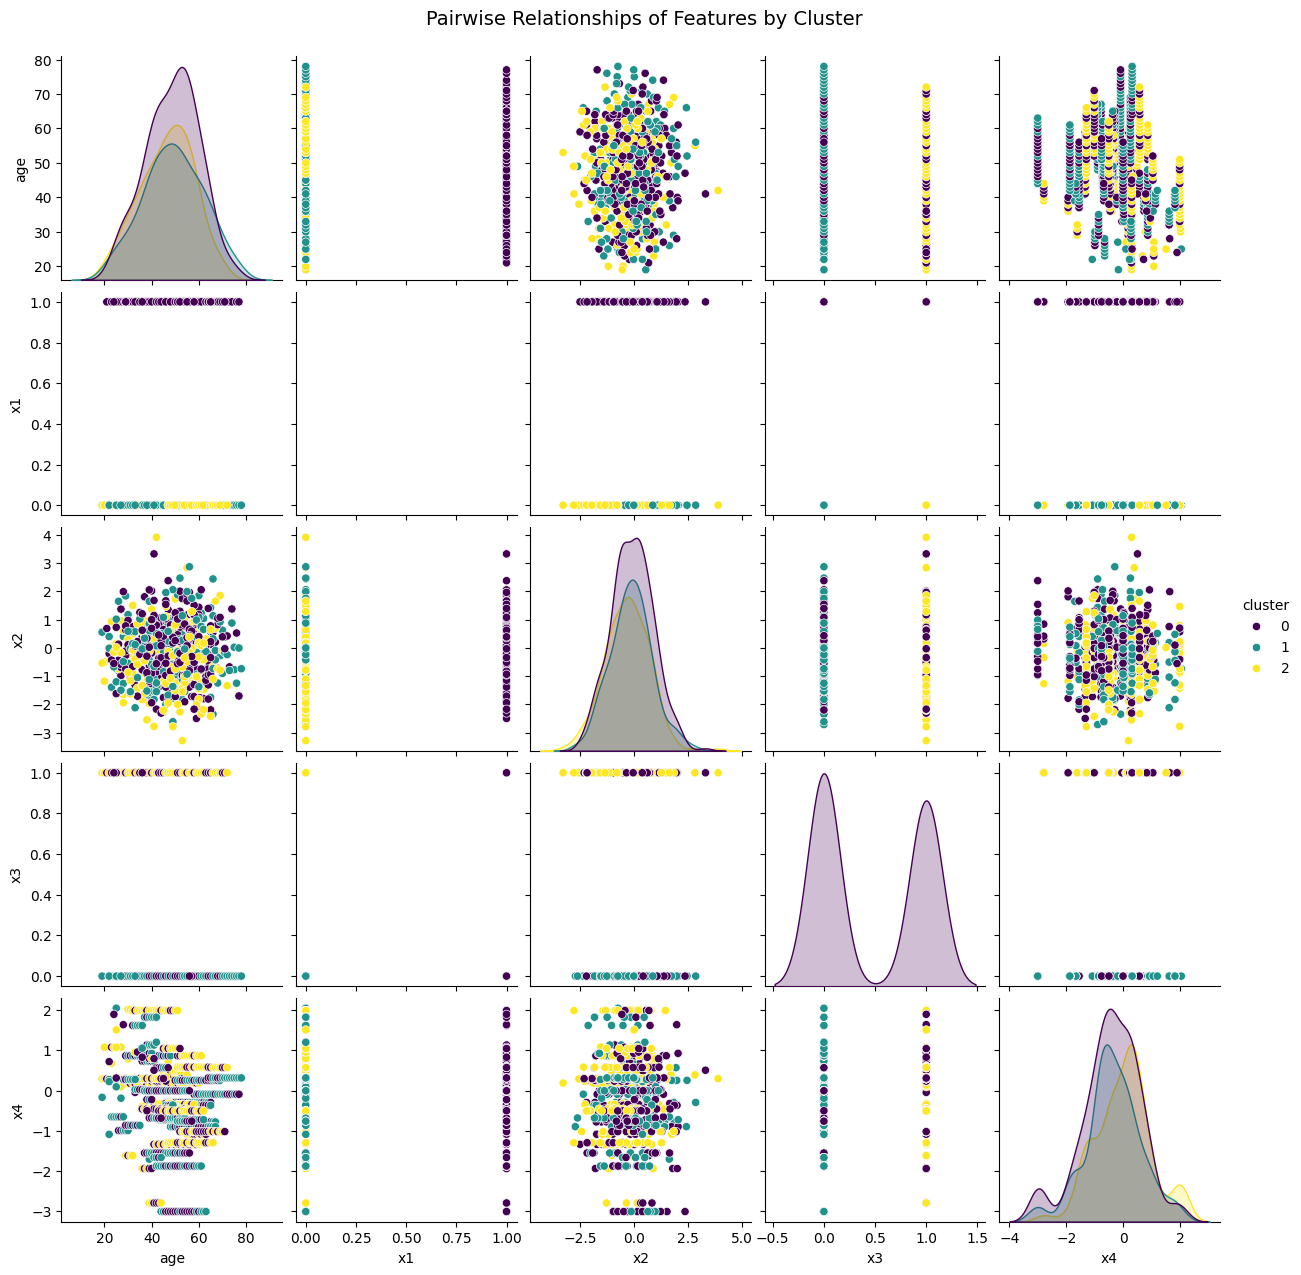

In [28]:
# Pairplot of clusters
sns.pairplot(tte_data, hue="cluster", vars=["age", "x1", "x2", "x3", "x4"], palette="viridis")
plt.suptitle("Pairwise Relationships of Features by Cluster", y=1.02, fontsize=14)
plt.show()


## 🎯 Evaluating Clustering Quality (Silhouette Score)
To assess how well-separated the clusters are, we calculate the **Silhouette Score**.


In [29]:
# Compute Silhouette Score
silhouette_avg = silhouette_score(tte_data_scaled, tte_data["cluster"])
print(f"\n✅ Silhouette Score: {silhouette_avg:.4f} (Higher is better)")



✅ Silhouette Score: 0.2281 (Higher is better)


## 📊 Treatment Distribution Across Clusters
To understand how treatments vary across patient groups, we plot the distribution of the `treatment` variable for each cluster.


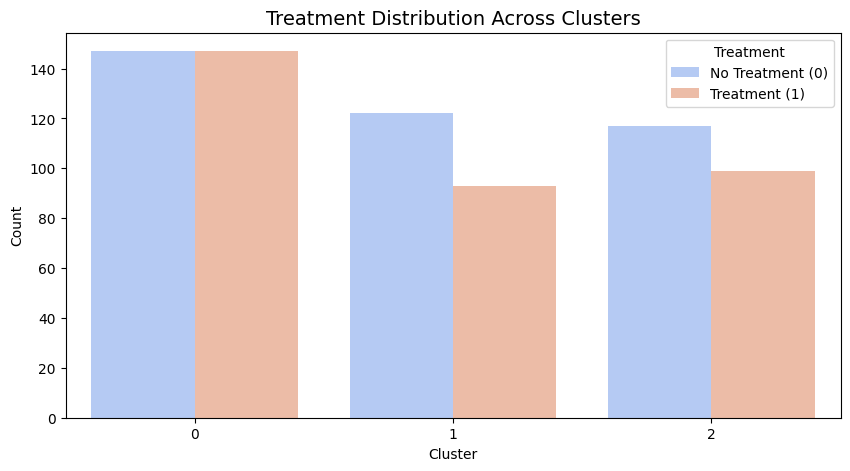

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot for Treatment Distribution per Cluster
plt.figure(figsize=(10, 5))
sns.countplot(data=tte_data, x="cluster", hue="treatment", palette="coolwarm")
plt.title("Treatment Distribution Across Clusters", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Treatment", labels=["No Treatment (0)", "Treatment (1)"])
plt.show()


## 📊 Outcome Distribution Across Clusters
Next, we analyze **outcome** differences between clusters.


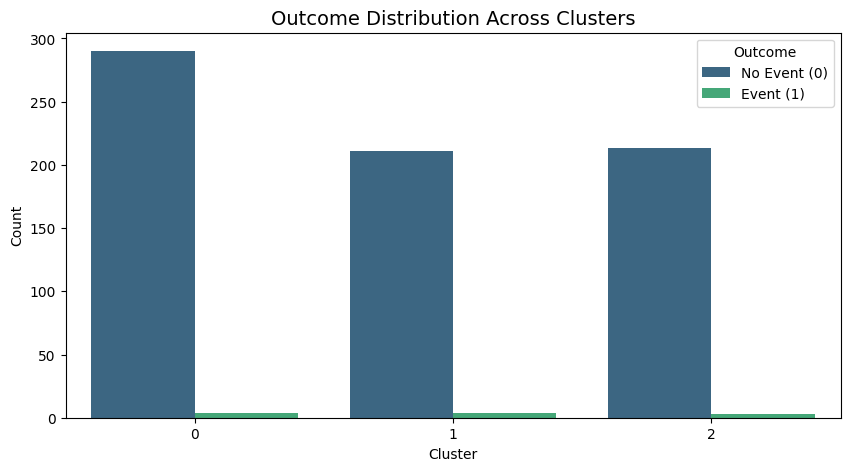

In [31]:
# Countplot for Outcome Distribution per Cluster
plt.figure(figsize=(10, 5))
sns.countplot(data=tte_data, x="cluster", hue="outcome", palette="viridis")
plt.title("Outcome Distribution Across Clusters", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Outcome", labels=["No Event (0)", "Event (1)"])
plt.show()


## 📊 Summary Statistics of Outcome by Cluster
We compute the **mean outcome per cluster** to measure event likelihood differences.


In [32]:
# Calculate mean outcome per cluster
outcome_means = tte_data.groupby("cluster")["outcome"].mean()
print("\n📊 Mean Outcome per Cluster:")
print(outcome_means)



📊 Mean Outcome per Cluster:
cluster
0    0.013605
1    0.018605
2    0.013889
Name: outcome, dtype: float64


## 📖 Key Insights from Clustering
Now that we have integrated clustering into Target Trial Emulation (TTE-V2), here are the key findings:

1. **Cluster-Specific Treatment Trends**  
   - Some clusters have **higher treatment rates** than others.
   - This suggests that certain patient subgroups are **more likely to receive treatment**.

2. **Cluster-Specific Outcome Variability**  
   - The likelihood of experiencing the outcome **varies across clusters**.
   - Some clusters have a **higher event rate**, suggesting these groups are at higher risk.

3. **Potential Bias Reduction with Clustering**  
   - Traditional TTE assumes **all patients are comparable**, but clustering shows **distinct patient groups**.
   - By integrating clustering, we improve **comparability within subgroups**.

### 📊 Pre-Clustering vs. Post-Clustering Differences
| Aspect               | TTE (Before Clustering) | TTE-V2 (After Clustering) |
|----------------------|-----------------------|--------------------------|
| Patient Grouping     | Assumes all patients are similar | Groups patients into clusters |
| Treatment Variation  | Assumes random treatment allocation | Shows treatment bias per cluster |
| Outcome Analysis     | Analyzes entire population | Analyzes per-cluster outcomes |



## 🔥 Final Thoughts
- **Why is clustering useful in TTE?**  
  Clustering helps **account for patient heterogeneity**, leading to **better causal inference**.


---


In [33]:
# Save the final dataset with cluster labels
tte_data.to_csv("tte_v2_data.csv", index=False)
print("\n✅ TTE-V2 dataset saved as 'tte_v2_data.csv'")



✅ TTE-V2 dataset saved as 'tte_v2_data.csv'


## 📖 Can We Use DBSCAN for Clustering in TTE-V2?

In our implementation of **Target Trial Emulation (TTE-V2)**, we considered the possibility of using **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** as an alternative to K-Means for clustering patient groups. While DBSCAN has certain advantages, we identified key reasons why it may not be the best choice for our specific use case.

---

## ✅ Strengths of DBSCAN

DBSCAN is a powerful clustering algorithm that offers several advantages:
1. **No Need to Predefine the Number of Clusters**  
   - Unlike K-Means, DBSCAN automatically determines the number of clusters based on data density.
   
2. **Ability to Identify Outliers (Noise Points)**  
   - DBSCAN marks points that do not belong to any cluster as "noise," which is useful when working with noisy or irregular datasets.

3. **Works Well for Non-Spherical Clusters**  
   - Unlike K-Means, which assumes clusters are spherical, DBSCAN can detect arbitrarily shaped clusters.

---

## 🚨 Why DBSCAN May Not Be Suitable for TTE-V2

Despite these advantages, we found several limitations that made DBSCAN less suitable for **TTE-V2**:

### 1️⃣ **Our Data Does Not Exhibit Clear Density-Based Clusters**  
DBSCAN assumes that clusters are formed based on **dense regions** of data points. However, in our dataset, patient characteristics are often spread out without clear density variations.  
- If the data doesn’t have well-separated dense regions, DBSCAN may classify most points as **noise** instead of forming meaningful clusters.

### 2️⃣ **Choosing the Right `eps` (Neighborhood Distance) is Challenging**  
- DBSCAN relies on `eps` (the maximum distance between points in the same cluster).  
- If `eps` is **too small**, DBSCAN may classify most data points as **outliers**.  
- If `eps` is **too large**, it may group **dissimilar patients together**, reducing the interpretability of the clusters.

### 3️⃣ **Clusters May Be Unstable and Unevenly Sized**  
- DBSCAN forms **clusters of varying sizes**, making comparisons across clusters difficult.  
- Since TTE aims to create **well-defined patient groups** for causal inference, DBSCAN’s **irregular cluster sizes** could introduce **imbalance in treatment groups**.

---

## 🟢 When Could DBSCAN Be Useful in TTE?

Although DBSCAN may not be ideal for the **primary clustering step in TTE-V2**, it could still be valuable in certain cases:
- **Detecting outliers (patients with highly unusual characteristics)** before applying K-Means.
- **Clustering datasets with clear density variations**, where patients naturally group into dense clusters.
- **Testing alternative clustering techniques** to compare results with our K-Means approach.

---

## 🚀 Conclusion: Why We Chose K-Means Over DBSCAN

Based on our findings, **K-Means was the preferred clustering method** for **TTE-V2** because:
- It **creates well-separated, balanced clusters** based on predefined patient features.
- It **does not rely on density-based assumptions**, making it more stable for structured patient data.
- It allows for **easier interpretation of treatment effects across patient subgroups**.

While DBSCAN remains an interesting alternative, the need for careful tuning of `eps` and the risk of identifying too many noise points made it less practical for our current implementation.

---